# Treinamento - Dataset 1

## Imports

In [3]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from tensorflow.keras.utils import normalize

from tensorflow.keras.layers import Input,LeakyReLU

from tensorflow.keras.initializers import he_normal

import gc
import datetime

from shutil import rmtree

In [4]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Desabilitando uso da GPU - apenas no caso da instalação do tensorflow com suporte a GPU

* O uso da GPU traz banefícios de desempenho para modelos médios e grandes apenas

In [5]:
# force CPU (make CPU visible)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)
tf.config.set_visible_devices([], 'GPU')  # hide the GPU
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Leitura dos dados

In [6]:
dataPath = r'D:\14--OneDrive\OneDrive\ML-SEA-2021\Rede_Teste_2'
#npzFname = 'training_data_sw_ar_clean.npz'
npzFname = 'training_data_sw_ar_raw.npz'

npz = np.load(os.path.join(dataPath, npzFname))

X_TRAIN = npz['X_TRAIN']
Y_TRAIN = npz['Y_TRAIN']

X_TEST = npz['X_TEST']
Y_TEST = npz['Y_TEST']

m_train = X_TRAIN.shape[0]
m_test = X_TEST.shape[0]
n_inp = X_TRAIN.shape[1]
n_out = Y_TRAIN.shape[1]
print('{:>30}{:8}'.format('Number of TRAINING samples:', m_train))
print('{:>30}{:8}'.format('Number of TEST samples:', m_test))
print('{:>30}{:8}'.format('Number of features:', n_inp))
print('{:>30}{:8}'.format('Number of labels:', n_out))

   Number of TRAINING samples:     950
       Number of TEST samples:     950
           Number of features:       2
             Number of labels:       1


## Normalização dos dados



### Definição da classe com método de normalização
É mais conveniente se utilizar uma classe pois sua instância guardará as informação da normalização 
que serão utilizadas no final do processo para desnormalizar a saída da rede

In [7]:
class normalizer:
    
    def __init__(self):       
        pass
    
    def set_norm(self, A, axis=0):
        self.mean = np.mean(A, axis=axis)
        self.std = np.std(A, axis=axis)
        
    def normalize(self, A):
        return (A - self.mean) / self.std
    
    def denormalize(self, A):
        return A * self.std + self.mean

### Criação e setup dos objetos normalizadores

In [8]:
inp_normalizer = normalizer()
inp_normalizer.set_norm(X_TRAIN)

out_normalizer = normalizer()
out_normalizer.set_norm(Y_TRAIN)

X_TRAIN_norm = inp_normalizer.normalize(X_TRAIN)
Y_TRAIN_norm = out_normalizer.normalize(Y_TRAIN)
X_TEST_norm = inp_normalizer.normalize(X_TEST)
Y_TEST_norm = out_normalizer.normalize(Y_TEST)

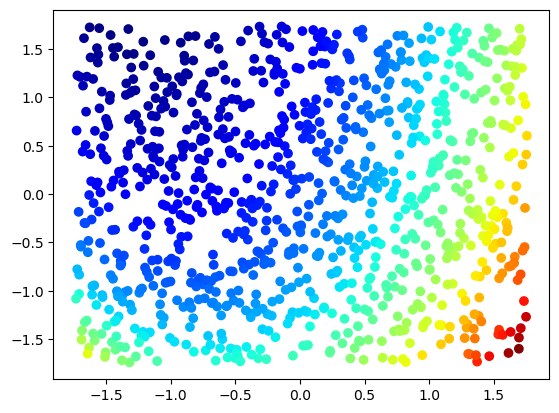

In [9]:
import matplotlib.pyplot as plt
plt.scatter(X_TRAIN_norm[:,0], X_TRAIN_norm[:,1], c=Y_TRAIN_norm[:,0], cmap='jet')
plt.show()

## Montagem do modelo / gráfico do Tensorflow

In [10]:
inp = Input(shape=(n_inp,))

n_prev = n_inp

x = inp

layers =[16,32,64,32,16]

for n_layer in layers:
    x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
              kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
    x = Activation('tanh')(x)
    n_prev = n_layer

x = Dense(n_out, input_dim=n_prev, use_bias = True, 
          kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)

output = Activation('linear')(x)

### Setup do otimizador, métricas e compilação dos modelos

In [11]:
adam = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1.e-8, decay=0.1, amsgrad=False)

metric1 = metrics.MeanSquaredError(name='mse', dtype=None)
metric2 = metrics.MeanAbsolutePercentageError(name='mape', dtype=None)

model = Model(inp,output)

model.compile(loss='mse',
              optimizer=adam,
              metrics = [metric2])

In [12]:
#log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit/model_sw_ar_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
abs_log_dir = os.path.abspath(log_dir)
print('conda activate tf_gpu')
print('tensorboard --logdir="{}"'.format(abs_log_dir))

conda activate tf_gpu
tensorboard --logdir="C:\Users\renat\logs\fit\model_sw_ar_2"


In [13]:
try:
    rmtree(abs_log_dir)
except Exception as e:
    print(e)

### Treinamento

In [15]:
#model.summary()

model.fit(X_TRAIN_norm, Y_TRAIN_norm,
          epochs=1000,
          batch_size=64,
         shuffle=True,
         verbose = 2,
         callbacks=[tensorboard_callback])

Epoch 1/1000
15/15 - 1s - loss: 1.4847e-04 - mape: 3.9264
Epoch 2/1000
15/15 - 0s - loss: 1.4455e-04 - mape: 3.6839
Epoch 3/1000
15/15 - 0s - loss: 1.5191e-04 - mape: 3.9433
Epoch 4/1000
15/15 - 0s - loss: 1.5204e-04 - mape: 3.7169
Epoch 5/1000
15/15 - 0s - loss: 1.5298e-04 - mape: 3.9613
Epoch 6/1000
15/15 - 0s - loss: 1.5020e-04 - mape: 3.4407
Epoch 7/1000
15/15 - 0s - loss: 1.4631e-04 - mape: 3.8014
Epoch 8/1000
15/15 - 0s - loss: 1.4899e-04 - mape: 3.5210
Epoch 9/1000
15/15 - 0s - loss: 1.4321e-04 - mape: 3.5888
Epoch 10/1000
15/15 - 0s - loss: 1.4372e-04 - mape: 3.5499
Epoch 11/1000
15/15 - 0s - loss: 1.5353e-04 - mape: 3.5790
Epoch 12/1000
15/15 - 0s - loss: 1.5264e-04 - mape: 3.9630
Epoch 13/1000
15/15 - 0s - loss: 1.5526e-04 - mape: 3.6690
Epoch 14/1000
15/15 - 0s - loss: 1.5644e-04 - mape: 3.9102
Epoch 15/1000
15/15 - 0s - loss: 1.5365e-04 - mape: 3.4869
Epoch 16/1000
15/15 - 0s - loss: 1.4385e-04 - mape: 3.7003
Epoch 17/1000
15/15 - 0s - loss: 1.4545e-04 - mape: 3.6449
Epoch 

Epoch 140/1000
15/15 - 0s - loss: 1.3321e-04 - mape: 3.2432
Epoch 141/1000
15/15 - 0s - loss: 1.3464e-04 - mape: 3.7824
Epoch 142/1000
15/15 - 0s - loss: 1.3584e-04 - mape: 3.2195
Epoch 143/1000
15/15 - 0s - loss: 1.3555e-04 - mape: 3.3496
Epoch 144/1000
15/15 - 0s - loss: 1.2909e-04 - mape: 3.2399
Epoch 145/1000
15/15 - 0s - loss: 1.3092e-04 - mape: 3.3298
Epoch 146/1000
15/15 - 0s - loss: 1.3679e-04 - mape: 3.6444
Epoch 147/1000
15/15 - 0s - loss: 1.3553e-04 - mape: 3.4646
Epoch 148/1000
15/15 - 0s - loss: 1.3177e-04 - mape: 3.5581
Epoch 149/1000
15/15 - 0s - loss: 1.3119e-04 - mape: 3.3931
Epoch 150/1000
15/15 - 0s - loss: 1.3594e-04 - mape: 3.4203
Epoch 151/1000
15/15 - 0s - loss: 1.3232e-04 - mape: 3.4310
Epoch 152/1000
15/15 - 0s - loss: 1.3125e-04 - mape: 3.1451
Epoch 153/1000
15/15 - 0s - loss: 1.3229e-04 - mape: 3.5458
Epoch 154/1000
15/15 - 0s - loss: 1.3103e-04 - mape: 3.4694
Epoch 155/1000
15/15 - 0s - loss: 1.3604e-04 - mape: 3.4107
Epoch 156/1000
15/15 - 0s - loss: 1.3309

Epoch 277/1000
15/15 - 0s - loss: 1.2521e-04 - mape: 3.2889
Epoch 278/1000
15/15 - 0s - loss: 1.2095e-04 - mape: 3.4352
Epoch 279/1000
15/15 - 0s - loss: 1.2241e-04 - mape: 3.3539
Epoch 280/1000
15/15 - 0s - loss: 1.2401e-04 - mape: 3.2700
Epoch 281/1000
15/15 - 0s - loss: 1.2572e-04 - mape: 3.4136
Epoch 282/1000
15/15 - 0s - loss: 1.2748e-04 - mape: 3.3722
Epoch 283/1000
15/15 - 0s - loss: 1.2605e-04 - mape: 3.2132
Epoch 284/1000
15/15 - 0s - loss: 1.2238e-04 - mape: 3.2590
Epoch 285/1000
15/15 - 0s - loss: 1.2226e-04 - mape: 3.6736
Epoch 286/1000
15/15 - 0s - loss: 1.2176e-04 - mape: 3.2953
Epoch 287/1000
15/15 - 0s - loss: 1.2088e-04 - mape: 3.4527
Epoch 288/1000
15/15 - 0s - loss: 1.2192e-04 - mape: 3.4433
Epoch 289/1000
15/15 - 0s - loss: 1.2414e-04 - mape: 3.5666
Epoch 290/1000
15/15 - 0s - loss: 1.2148e-04 - mape: 3.4185
Epoch 291/1000
15/15 - 0s - loss: 1.2231e-04 - mape: 3.2463
Epoch 292/1000
15/15 - 0s - loss: 1.2156e-04 - mape: 3.3950
Epoch 293/1000
15/15 - 0s - loss: 1.2490

Epoch 414/1000
15/15 - 0s - loss: 1.1693e-04 - mape: 3.1850
Epoch 415/1000
15/15 - 0s - loss: 1.1570e-04 - mape: 3.5242
Epoch 416/1000
15/15 - 0s - loss: 1.1782e-04 - mape: 3.0034
Epoch 417/1000
15/15 - 0s - loss: 1.1527e-04 - mape: 3.5007
Epoch 418/1000
15/15 - 0s - loss: 1.1423e-04 - mape: 3.1731
Epoch 419/1000
15/15 - 0s - loss: 1.1407e-04 - mape: 3.3703
Epoch 420/1000
15/15 - 0s - loss: 1.1426e-04 - mape: 3.3484
Epoch 421/1000
15/15 - 0s - loss: 1.1305e-04 - mape: 3.2616
Epoch 422/1000
15/15 - 0s - loss: 1.1391e-04 - mape: 3.3592
Epoch 423/1000
15/15 - 0s - loss: 1.1498e-04 - mape: 3.4012
Epoch 424/1000
15/15 - 0s - loss: 1.1478e-04 - mape: 3.4644
Epoch 425/1000
15/15 - 0s - loss: 1.1622e-04 - mape: 3.0122
Epoch 426/1000
15/15 - 0s - loss: 1.1321e-04 - mape: 3.2583
Epoch 427/1000
15/15 - 0s - loss: 1.1330e-04 - mape: 3.3858
Epoch 428/1000
15/15 - 0s - loss: 1.1336e-04 - mape: 3.3135
Epoch 429/1000
15/15 - 0s - loss: 1.1239e-04 - mape: 3.3297
Epoch 430/1000
15/15 - 0s - loss: 1.1236

Epoch 551/1000
15/15 - 0s - loss: 1.0852e-04 - mape: 3.2585
Epoch 552/1000
15/15 - 0s - loss: 1.0999e-04 - mape: 3.4659
Epoch 553/1000
15/15 - 0s - loss: 1.1005e-04 - mape: 3.0499
Epoch 554/1000
15/15 - 0s - loss: 1.0670e-04 - mape: 3.2230
Epoch 555/1000
15/15 - 0s - loss: 1.0735e-04 - mape: 3.1050
Epoch 556/1000
15/15 - 0s - loss: 1.0885e-04 - mape: 3.3906
Epoch 557/1000
15/15 - 0s - loss: 1.0992e-04 - mape: 3.3716
Epoch 558/1000
15/15 - 0s - loss: 1.0853e-04 - mape: 3.1872
Epoch 559/1000
15/15 - 0s - loss: 1.0584e-04 - mape: 3.1742
Epoch 560/1000
15/15 - 0s - loss: 1.0766e-04 - mape: 3.3320
Epoch 561/1000
15/15 - 0s - loss: 1.0646e-04 - mape: 3.2288
Epoch 562/1000
15/15 - 0s - loss: 1.0791e-04 - mape: 3.3711
Epoch 563/1000
15/15 - 0s - loss: 1.0776e-04 - mape: 3.2409
Epoch 564/1000
15/15 - 0s - loss: 1.0884e-04 - mape: 3.1582
Epoch 565/1000
15/15 - 0s - loss: 1.0992e-04 - mape: 3.0655
Epoch 566/1000
15/15 - 0s - loss: 1.1369e-04 - mape: 3.7612
Epoch 567/1000
15/15 - 0s - loss: 1.0880

Epoch 688/1000
15/15 - 0s - loss: 1.0138e-04 - mape: 3.0721
Epoch 689/1000
15/15 - 0s - loss: 1.0231e-04 - mape: 3.3993
Epoch 690/1000
15/15 - 0s - loss: 1.0470e-04 - mape: 3.2023
Epoch 691/1000
15/15 - 0s - loss: 1.0307e-04 - mape: 3.1961
Epoch 692/1000
15/15 - 0s - loss: 1.0302e-04 - mape: 3.1905
Epoch 693/1000
15/15 - 0s - loss: 1.0175e-04 - mape: 3.3233
Epoch 694/1000
15/15 - 0s - loss: 1.0360e-04 - mape: 3.2591
Epoch 695/1000
15/15 - 0s - loss: 1.0210e-04 - mape: 3.2559
Epoch 696/1000
15/15 - 0s - loss: 1.0250e-04 - mape: 3.0879
Epoch 697/1000
15/15 - 0s - loss: 1.0860e-04 - mape: 3.3513
Epoch 698/1000
15/15 - 0s - loss: 1.0751e-04 - mape: 3.3008
Epoch 699/1000
15/15 - 0s - loss: 1.0621e-04 - mape: 3.0370
Epoch 700/1000
15/15 - 0s - loss: 1.0167e-04 - mape: 3.1314
Epoch 701/1000
15/15 - 0s - loss: 1.0065e-04 - mape: 3.0675
Epoch 702/1000
15/15 - 0s - loss: 1.0092e-04 - mape: 3.1953
Epoch 703/1000
15/15 - 0s - loss: 1.0296e-04 - mape: 3.2945
Epoch 704/1000
15/15 - 0s - loss: 1.0573

Epoch 825/1000
15/15 - 0s - loss: 1.0028e-04 - mape: 3.0118
Epoch 826/1000
15/15 - 0s - loss: 9.7883e-05 - mape: 3.2438
Epoch 827/1000
15/15 - 0s - loss: 9.8140e-05 - mape: 3.1296
Epoch 828/1000
15/15 - 0s - loss: 9.8204e-05 - mape: 3.1376
Epoch 829/1000
15/15 - 0s - loss: 9.8994e-05 - mape: 3.2749
Epoch 830/1000
15/15 - 0s - loss: 9.7544e-05 - mape: 3.0751
Epoch 831/1000
15/15 - 0s - loss: 9.7767e-05 - mape: 3.2339
Epoch 832/1000
15/15 - 0s - loss: 9.8188e-05 - mape: 3.2295
Epoch 833/1000
15/15 - 0s - loss: 1.0221e-04 - mape: 3.3387
Epoch 834/1000
15/15 - 0s - loss: 9.9569e-05 - mape: 2.8413
Epoch 835/1000
15/15 - 0s - loss: 9.7161e-05 - mape: 3.1211
Epoch 836/1000
15/15 - 0s - loss: 9.6977e-05 - mape: 3.1987
Epoch 837/1000
15/15 - 0s - loss: 9.6671e-05 - mape: 3.1628
Epoch 838/1000
15/15 - 0s - loss: 9.6936e-05 - mape: 3.1648
Epoch 839/1000
15/15 - 0s - loss: 9.8828e-05 - mape: 3.1930
Epoch 840/1000
15/15 - 0s - loss: 9.8638e-05 - mape: 3.1956
Epoch 841/1000
15/15 - 0s - loss: 9.6052

Epoch 962/1000
15/15 - 0s - loss: 9.3334e-05 - mape: 3.1496
Epoch 963/1000
15/15 - 0s - loss: 9.4134e-05 - mape: 3.2963
Epoch 964/1000
15/15 - 0s - loss: 9.4141e-05 - mape: 3.2463
Epoch 965/1000
15/15 - 0s - loss: 9.5063e-05 - mape: 3.0310
Epoch 966/1000
15/15 - 0s - loss: 9.4600e-05 - mape: 3.0639
Epoch 967/1000
15/15 - 0s - loss: 9.5121e-05 - mape: 3.2898
Epoch 968/1000
15/15 - 0s - loss: 9.6554e-05 - mape: 3.2776
Epoch 969/1000
15/15 - 0s - loss: 9.4668e-05 - mape: 2.9665
Epoch 970/1000
15/15 - 0s - loss: 9.2855e-05 - mape: 3.2787
Epoch 971/1000
15/15 - 0s - loss: 9.2694e-05 - mape: 3.1383
Epoch 972/1000
15/15 - 0s - loss: 9.2660e-05 - mape: 3.0921
Epoch 973/1000
15/15 - 0s - loss: 9.3207e-05 - mape: 3.0682
Epoch 974/1000
15/15 - 0s - loss: 9.3894e-05 - mape: 3.2802
Epoch 975/1000
15/15 - 0s - loss: 9.4078e-05 - mape: 3.0919
Epoch 976/1000
15/15 - 0s - loss: 9.2111e-05 - mape: 3.1610
Epoch 977/1000
15/15 - 0s - loss: 9.6125e-05 - mape: 3.1142
Epoch 978/1000
15/15 - 0s - loss: 9.3375

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0     

In [19]:
model.evaluate(x=X_TEST_norm, y=Y_TEST_norm, batch_size=32, verbose=0,)

[9.054801921593025e-05, 3.0316896438598633]

## Plot com dataset de validação com DOE fatorial

In [ ]:
npzFname = 'dataset_v1_valid200_sw_ar.npz'

npz = np.load(os.path.join(dataPath, npzFname))

features = ['sw', 'ar']
labels = ['w_fuel']

valid_data = npz['data']
valid_cols = list(npz['columns'])

j = [valid_cols.index(k) for k in features]

X_VALID = valid_data[:,j]

X_VALID_norm = inp_normalizer.normalize(X_VALID)

In [ ]:
Y_PREDICT_norm = model.predict(X_VALID_norm)

Y_PREDICT = out_normalizer.denormalize(Y_PREDICT_norm)

XX = X_VALID[:,0].reshape((25,8))

YY = Y_PREDICT[:,0].reshape((25,8))

ARs = np.linspace(7,14,8)
AR_labels = ['AR={:4.1f}'.format(a) for a in ARs]

j = valid_cols.index('w_fuel')

Y_VALID = valid_data[:,j]

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(16,9))
ax.plot(XX,YY_V, linestyle='--', color='k')
ax.plot(XX,YY, label=AR_labels)
ax.grid()
ax.set_xlabel('$S_W$ [$m^2$]')
ax.set_ylabel('Mission Fuel [kg]')
ax.legend()
plt.show()

In [ ]:
YY_V